In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, rc
from mpl_toolkits.mplot3d import Axes3D
from cot.config import SAVE_DIR

WIDTH = 5.5            # inches (from ICML style file)
HEIGHT = 5.5 / 1.5     # golden ratio


rc('font', family='serif', size=8)
usetex = not subprocess.run(['which', 'pdflatex']).returncode
rc('text', usetex=usetex)
if usetex:
    rc('text.latex', preamble=r'\usepackage{times}')

/home/vivc/.local/share/texlive/2022/bin/x86_64-linux/pdflatex


In [3]:
exp = 1
attention_eval = True
pb1, pb2, pb3, pb4 = "polynomial", "polynomial-no-cot", "parity", "parity-no-cot"
problems = [pb1, pb2, pb3, pb4]

save_dir = SAVE_DIR / f"res-cot-exp{exp}"

x = np.arange(4, 32)
y = np.arange(4, 64)
t = np.arange(0, 1001, 10)

Z1, Z2, Z3, Z4 = {}, {}, {}, {}

for problem in problems:
    Z1[problem] = np.load(save_dir / f"train_acc_{problem}.npy")
    Z2[problem] = np.load(save_dir / f"test_acc_{problem}.npy")

    if attention_eval:
        Z3[problem] = np.load(save_dir / f"attn0_{problem}.npy")
        Z4[problem] = np.load(save_dir / f"attn1_{problem}.npy")

exp = 2
save_dir = SAVE_DIR / f"res-cot-exp{exp}"
for problem in [pb1, pb3]:
    Z1[problem + "-1l"] = np.load(save_dir / f"train_acc_{problem}.npy")
    Z2[problem + "-1l"] = np.load(save_dir / f"test_acc_{problem}.npy")

In [4]:
for Zi in (
    list(Z1.values())
    + list(Z2.values())
    + list(Z3.values())
    + list(Z4.values())
):
    tmp = np.repeat(Zi.mean(axis=1)[:, np.newaxis, :], Zi.shape[1], axis=1)
    Zi[Zi == -1] = tmp[Zi == -1]
    # Zi[Zi == -1] = .5
    # pass

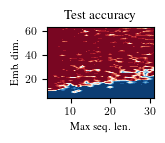

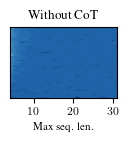

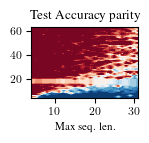

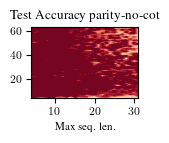

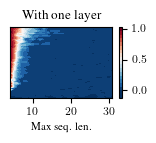

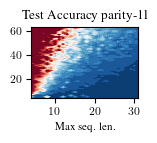

In [5]:
ind = -5
for i, pb in enumerate(Z2.keys()):
    if i == 4:
        fig, ax = plt.subplots(1, 1, figsize=(.3 * WIDTH, .25 * HEIGHT))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(.25 * WIDTH, .25 * HEIGHT))

    data = Z2[pb]
    X, Y = np.meshgrid(x, y)
    a = ax.contourf(X, Y, data[:, :, ind].T, cmap='RdBu_r', vmin=0, vmax=1, levels=20)
    ax.set_title(f'Test Accuracy {pb}')
    ax.set_xlabel('Max seq. len.')

    if i == 0:
        ax.set_ylabel('Emb. dim.')
        ax.set_title(f'Test accuracy')
        fig.savefig('scal-polynomial.pdf', bbox_inches='tight')
    if i == 1:
        ax.set_yticks([])
        ax.set_title(f'Without CoT')
        fig.savefig('scal-no-cot.pdf', bbox_inches='tight')
    if i == 4:
        c = fig.colorbar(a)
        c.set_ticks([0, .5, 1])
        ax.set_yticks([])
        ax.set_title(f'With one layer')
        fig.savefig('scal-1l.pdf', bbox_inches='tight')
    # fig.savefig('polynomial.pdf', bbox_inches='tight')

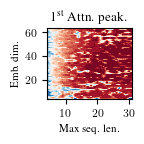

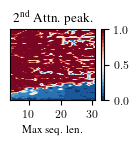

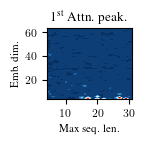

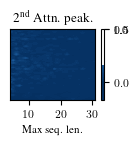

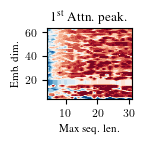

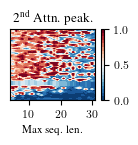

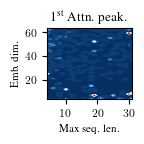

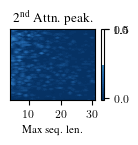

In [15]:
for i, pb in enumerate(problems):
    data = Z3[pb]
    X, Y = np.meshgrid(x, y)
    fig, ax = plt.subplots(1, 1, figsize=(.2 * WIDTH, .25 * HEIGHT))
    a = ax.contourf(X, Y, data[:, :, ind].T, cmap='RdBu_r', vmin=0, vmax=1, levels=20)
    ax.set_xlabel('Max seq. len.')
    ax.set_ylabel('Emb. dim.')
    ax.set_title(r'1\textsuperscript{st} Attn. peak.')

    if i == 0:
        fig.savefig('polynomial_attn0.pdf', bbox_inches='tight')
    if i == 2:
        fig.savefig('parity_attn0.pdf', bbox_inches='tight')

    data = Z4[pb]
    X, Y = np.meshgrid(x, y)
    fig, ax = plt.subplots(1, 1, figsize=(.25 * WIDTH, .25 * HEIGHT))
    a = ax.contourf(X, Y, data[:, :, ind].T, cmap='RdBu_r', vmin=0, vmax=1, levels=20)
    c = fig.colorbar(a)
    c.set_ticks([0, .5, 1])
    ax.set_xlabel('Max seq. len.')
    ax.set_yticks([])
    ax.set_title(r'2\textsuperscript{nd} Attn. peak.')
    if i == 0:
        fig.savefig('polynomial_attn1.pdf', bbox_inches='tight')
    if i == 2:
        fig.savefig('parity_attn1.pdf', bbox_inches='tight')

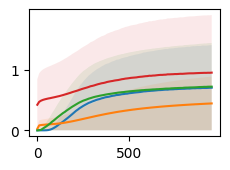

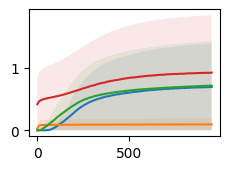

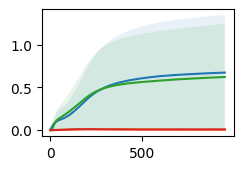

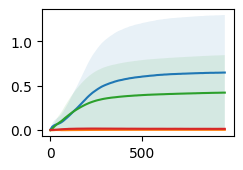

In [14]:
t = np.arange(0, 1001, 10)[:-5]


for Z in [Z1, Z2, Z3, Z4]:
    fig, ax = plt.subplots(1, 1, figsize=(.45 * WIDTH, .45 * HEIGHT))
    for pb in problems:
        data = Z[pb].reshape(-1, Z[pb].shape[-1])
        tmp = data[data.std(axis=1) != 0][:, :-5]
        tmp_mean = tmp.mean(axis=0)
        tmp_std = tmp.mean(axis=0)
        ax.plot(t, tmp_mean)
        ax.fill_between(t, tmp_mean + tmp_std, tmp_mean - tmp_std, alpha=.1)

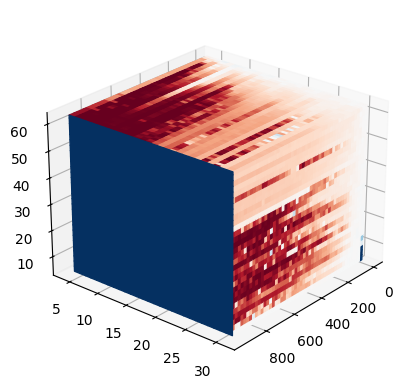

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

T, X = np.meshgrid(t, x)
ax.plot_surface(T, X, np.full_like(T, y[-1]), facecolors=cm.RdBu_r(data[:,-1,:]), shade=False)
T, Y = np.meshgrid(t, y)
ax.plot_surface(T, np.full_like(T, x[-1]), Y, facecolors=cm.RdBu_r(data[-1,:,:]), shade=False)
X, Y = np.meshgrid(x, y)
ax.plot_surface(np.full_like(X, t[-1]), X, Y, facecolors=cm.RdBu_r(data[:,:,-1].T), shade=False)
ax.view_init(elev=25, azim=40)
